# Collaborator Analysis

This notebook contains the generic code for extracting means. We shall use this code for all our analysis.

## Importing relevant libraries, and loading relevant files

In [1]:
# Importing relevant libraries

import pandas as pd
from scipy import stats
import scipy.stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mean
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec

# Fixing a random state
np.random.seed(3)

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
    
    
from config_reader import read_config

/usr/local/lib/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
indir = "/Users/sm9654/desktop/NYUAD/nyuad-research/retraction_openalex/retraction_effects_on_academic_careers/data/processed/author_matching/"

# Reading paths
paths = read_config()
# Path to where we will save our processed files
OUTDIR = paths['PLOTS_FOLDER_LOCAL']


In [3]:
# Reading relevant files
df_treatment_org = pd.read_csv(indir+
                           "RWMAG_rematched_treatment_augmented_rematching_30perc.csv")

df_control_org = pd.read_csv(indir+\
                           "RWMAG_rematched_control_augmented_rematching_30perc.csv")


In [4]:
# Only extracting authors and matches with same country

df_same_country_matches = pd.read_csv(indir+"matches_with_same_country_30perc.csv")

df_treatment_org = df_treatment_org.merge(df_same_country_matches, on='MAGAID')

df_control_org = df_control_org.merge(df_same_country_matches, on=['MAGAID','MatchMAGAID'])

In [5]:
df_treatment_org.RetractorMajority.value_counts()

RetractorMajority
other retractor    987
author             323
journal            281
Name: count, dtype: int64

In [6]:
df_temp = df_control_org.drop_duplicates(subset=['MAGAID','MatchMAGAID'])
(df_temp['MAGCumCollaboratorsAtRetraction'] - df_temp['MatchMAGCumCollaboratorsAtRetraction']).describe()

count    926.000000
mean       1.647948
std        9.910695
min      -35.000000
25%        0.000000
50%        0.000000
75%        1.000000
max       79.000000
dtype: float64

In [7]:
df_treatment_org.head(2)

,MAGAID,Record ID,MAGPID,RetractionYear,MAGRetractionYearAffID,MAGRetractionYearAffRank,MAGRetractionYearAffYear,MAGrootFID,MAGrootFIDMaxPercent,GenderizeGender,...,NumOpenTriads,NumTriadsClosed,NC,OriginalPaperYear,AltmetricScoreAtRetraction,DifferencePublicationAndRetractionYear,DifferencePublicationAndRetractionYearCategorical,AttentionCategorical,Unnamed: 0,MatchMAGAID
0,9474215,7285.0,1.985944e+09,2015.0,79576946.0,17,2003.0,86803240.0,0.340102,male,...,60,1,0.016667,2014.0,47.0,1.0,0-1 year,high,3,2.169122e+09
1,51110233,6341.0,2.013146e+09,2015.0,184565670.0,301-400,2015.0,86803240.0,0.371429,female,...,601,0,0.000000,2012.0,1.0,3.0,2-5 years,low,7,2.115616e+09


In [8]:
df_control_org.head(2)

,MAGAID,MatchMAGAID,Record ID,MAGPID,RetractionYear,MAGRetractionYearAffID,MAGRetractionYearAffRank,MAGRetractionYearAffYear,MatchMAGRetractionYearAffID,MatchMAGRetractionYearAffYear,...,NumNewCollaboratorsW5,NumOpenTriads,NumTriadsClosed,NC,OriginalPaperYear,AltmetricScoreAtRetraction,DifferencePublicationAndRetractionYear,DifferencePublicationAndRetractionYearCategorical,AttentionCategorical,Unnamed: 0
0,9474215,2.169122e+09,7285.0,1.985944e+09,2015.0,79576946.0,17,2003.0,79576946.0,1999.0,...,71,246,1,0.004065,2014.0,47.0,1.0,0-1 year,high,3
1,51110233,2.115616e+09,6341.0,2.013146e+09,2015.0,184565670.0,301-400,2015.0,84392919.0,2015.0,...,31,1663,2,0.001203,2012.0,1.0,3.0,2-5 years,low,7


In [9]:
df_treatment_org.drop_duplicates(subset='MAGPID')['ReasonPropagatedMajorityOfMajority'].value_counts(dropna=False)

ReasonPropagatedMajorityOfMajority
mistake       169
misconduct    120
plagiarism    110
other         104
Name: count, dtype: int64

In [10]:
df_treatment_org.drop_duplicates(subset='MAGAID')['RetractorMajority'].value_counts(dropna=False)

RetractorMajority
other retractor    338
author             183
journal            111
Name: count, dtype: int64

In [11]:
df_treatment_org.MAGPID.nunique()

503

In [12]:
# Initializing the copy of treatment and control that shall be used across different analysis.
df_treatment = None
df_control = None
df_treatment_for_barplot = None

In [13]:
df_treatment_org['MAGAID'].nunique(), df_control_org['MAGAID'].nunique()

(632, 632)

## Data Filtering

In this function, we shall conduct three kinds of filtering:

1. **Removing outliers:** This will require a outlier_filtering_type variable and a threshold to be used for the IQR range or for the max number of collaborators. 

2. **Removing attrited authors:** This will require a flag whether to remove attrited authors or not.

3. **Removing authors with no triad info:** This will require a flag whether to remove authors with no triad info.

In [14]:
def filter_data(outlier_filtering_type='iqr', outlier_threshold=1.5,
                remove_attrited=False, remove_triad_NaNs=False):
    
    global df_treatment
    global df_control
    
    # Let us first copy the original treatment and control
    df_treatment = df_treatment_org.copy()
    df_control = df_control_org.copy()
    
    # Now let us remove outliers
    if outlier_filtering_type == 'iqr':
        print("Removing outliers from treatment using IQR")
        k = outlier_threshold
        Q1 = df_treatment.drop_duplicates(subset='MAGAID').MAGCumCollaboratorsAtRetraction.quantile(0.25)
        Q3 = df_treatment.drop_duplicates(subset='MAGAID').MAGCumCollaboratorsAtRetraction.quantile(0.75)
        IQR = Q3 - Q1
        fence_low  = Q1-k*IQR
        fence_high = Q3+k*IQR
        print("fence low:", fence_low, "fence high:", fence_high)
        
        df_treatment_filtered = df_treatment[df_treatment.MAGCumCollaboratorsAtRetraction.ge(fence_low) \
                                        & df_treatment.MAGCumCollaboratorsAtRetraction.le(fence_high)]
        print("Removed:",
              df_treatment.MAGAID.unique().shape[0]-df_treatment_filtered.MAGAID.unique().shape[0],"scientists and",
             df_treatment.MAGPID.unique().shape[0]-df_treatment_filtered.MAGPID.unique().shape[0],"papers yielding",
             df_treatment_filtered.MAGAID.unique().shape,"scientists and",
              df_treatment_filtered.MAGPID.unique().shape,"papers.")
        
        df_treatment = df_treatment_filtered.copy()
        df_control = df_control[df_control.MAGAID.isin(df_treatment.MAGAID.unique())]
        
    elif outlier_filtering_type == 'numcollaborators':
        print("Removing outliers from treatment using number of collaborators")
        
        df_treatment_filtered = df_treatment[df_treatment.MAGCumCollaboratorsAtRetraction.le(outlier_threshold)]
        print("Removed:",
              df_treatment.MAGAID.unique().shape[0]-df_treatment_filtered.MAGAID.unique().shape[0],"scientists and",
             df_treatment.MAGPID.unique().shape[0]-df_treatment_filtered.MAGPID.unique().shape[0],"papers yielding",
             df_treatment_filtered.MAGAID.unique().shape,"scientists and",
              df_treatment_filtered.MAGPID.unique().shape,"papers.")
        
        df_treatment = df_treatment_filtered.copy()
        df_control = df_control[df_control.MAGAID.isin(df_treatment.MAGAID.unique())]
    
#     # Now we adjust the control accordingly
#     if outlier_filtering_type in ['iqr', 'numcollaborators']:
#         print("Removing outliers from control")
#         # Now we do the same thing for control
#         # Let us first get the max number of collaborators
#         max_collaborators_treatment = df_treatment.MAGCumCollaborators.max()
#         df_control = df_control[df_control.MatchMAGCumCollaborators.le(max_collaborators_treatment)]
#         # Now we check if there is anything in treatment that needs to be removed

#         df_treatment = df_treatment[df_treatment.MAGAID.isin(df_control.MAGAID.unique())]

#         print("Total scientists left after filtering for control:",
#               df_treatment.MAGAID.nunique(),"with total papers:",df_treatment.MAGPID.nunique())
        
    if remove_attrited:
        #Let us first extract activity of scientists
        print("Removing Attrited Authors..")
        
        years_active_threshold = 0

        # Reading the activity of treatment post retraction
        df_treatment_activity = pd.read_csv("../../../data/attrition_postNHB/retracted_authors_attrition_info_postNHB.csv")

        # Only getting MAGAIDs that exist post-retraction
        lst_treatment_active_magaids = df_treatment_activity[df_treatment_activity.AttritionNew == 0]\
            .MAGAID.unique().tolist()

        # Reassigning Treatment
        df_treatment = df_treatment[df_treatment.MAGAID.isin(lst_treatment_active_magaids)]

#         df_control_activity = pd.read_csv("../../../data/main/control_activity_post_retraction_rematching.csv")

#         lst_control_active_magaids = df_control_activity[df_control_activity.YearsActive.gt(years_active_threshold)]\
#             .MatchMAGAID.unique().tolist()

        df_control = df_control[df_control.MAGAID.isin(lst_treatment_active_magaids)]
        
        #df_treatment = df_treatment[df_treatment.MAGAID.isin(df_control.MAGAID.unique())]

        print("Authors left after removing attrited:",df_control.MAGAID.nunique())
    
    if remove_triad_NaNs:
        # Let us first modify treatment and control to include only scientists which have opportunity to form triads
        magaids_treatment_noOpenTriads = df_treatment[df_treatment.NumOpenTriads.isna()]['MAGAID'].unique()
        df_treatment = df_treatment[~df_treatment.MAGAID.isin(magaids_treatment_noOpenTriads)]
        df_control = df_control[~df_control.MAGAID.isin(magaids_treatment_noOpenTriads)]

## Computing Confidence Intervals

In [15]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

## Computing the effect, size and significance

In [16]:
def extract_means(outcome=None, stratification_key=None, stratification_value=None, root='overall', frac=None,
                 test='ks', alpha=0.05, printflag=False):
    
    df_treatment_i = df_treatment[['MAGAID',outcome]]\
                            .drop_duplicates()

    df_control_i = df_control[['MAGAID','MatchMAGAID',outcome]]\
                        .drop_duplicates()
        
    if(stratification_key):
        # The stratification key here means if we want to stratify the data into say male vs. female 

        df_treatment_i = df_treatment[df_treatment[stratification_key].eq(stratification_value)]\
                                          [['MAGAID',outcome]]\
                                            .drop_duplicates()

        df_control_i = df_control[df_control[stratification_key].eq(stratification_value)]\
                            [['MAGAID','MatchMAGAID',outcome]]\
                            .drop_duplicates()

    if(frac):
        # This means the function may have been called for bootstrapping
        df_treatment_i = df_treatment_i.sample(frac=frac, replace=True)
        selected_magaids = df_treatment_i.MAGAID.unique()
        df_control_i = df_control_i[df_control_i.MAGAID.isin(selected_magaids)]
    
    # Getting the average match
    df_avg_control = df_control_i.groupby("MAGAID")[outcome].mean()
    
    # Merging the treatment and control to get statistical test
    df_merged = df_treatment_i.\
                    rename(columns={outcome:outcome+"Treatment"}).\
                    merge(df_avg_control.reset_index().rename(columns={outcome:outcome+"Control"}),
                          on='MAGAID')
    
    # Getting the average treatment
    mean_treatment_i = float(df_merged[outcome+'Treatment'].mean())
    
    # Getting the average control
    mean_control_i = float(df_merged[outcome+'Control'].mean())
    
    # Getting the number of samples
    n_samples = df_merged.shape[0]
    
    lst_delta = (df_merged[outcome+'Treatment'] - df_merged[outcome+'Control']).tolist()
    delta_mean, conf_lower, conf_upper = mean_confidence_interval(lst_delta, confidence=0.95)
    #print(n_samples, delta_mean, conf_lower,conf_upper)
    
    # Now doing the statistical test
    pvalue_welch, pvalue_wilcoxon, pvalue_ks = -1,-1,-1
    
    try:
        teststats_welch = stats.ttest_ind(df_merged[outcome+'Treatment'], 
                                        df_merged[outcome+'Control'], equal_var=False)
        _, pvalue_welch = teststats_welch
    except:
        "do nothing"
    
    try:
        teststats_wilcoxon = stats.wilcoxon(df_merged[outcome+'Treatment'], 
                                        df_merged[outcome+'Control'])
        _, pvalue_wilcoxon = teststats_wilcoxon
    except:
        "do nothing"
        
    try:
        teststats_ks = stats.ks_2samp(df_merged[outcome+'Treatment'], 
                                        df_merged[outcome+'Control'])
        _, pvalue_ks = teststats_ks
        
    except:
        "do nothing"
    
    
    
    if(printflag):
        
        print_string = ""

        if(mean_treatment_i > mean_control_i):
            if(pvalue <= alpha):

                print_string = "Output for **" + root + \
                    "** (<span style='color:red'>treatment (" +str(n_samples)+ ")</span>, <span style='color:green'>control</span>):  "+\
                    "<u><span style='color:red'>**"+str(mean_treatment_i)+"**</span></u>, "+\
                    "<span style='color:green'>"+str(mean_control_i)+"</span>"

            else:
                print_string = "Output for **" + root + \
                    "** (<span style='color:red'>treatment (" +str(n_samples)+ ")</span>, <span style='color:green'>control</span>):  "+\
                    "<span style='color:red'>**"+str(mean_treatment_i)+"**</span>, "+\
                    "<span style='color:green'>"+str(mean_control_i)+"</span>"

        else:
            if(pvalue <= alpha):
                print_string = "Output for **" + root + \
                    "** (<span style='color:red'>treatment (" +str(n_samples)+ ")</span>, <span style='color:green'>control</span>):  "+\
                    "<span style='color:red'>"+str(mean_treatment_i)+"</span>, "+\
                    "<u><span style='color:green'>**"+str(mean_control_i)+"**</span></u>"
            else:

                print_string = "Output for **" + root + \
                    "** (<span style='color:red'>treatment (" +str(n_samples)+ ")</span>, <span style='color:green'>control</span>):  "+\
                    "<span style='color:red'>"+str(mean_treatment_i)+"</span>, "+\
                    "<span style='color:green'>**"+str(mean_control_i)+"**</span>"

        printmd(print_string)
    
    return n_samples, mean_treatment_i, mean_control_i, pvalue_welch, pvalue_wilcoxon, pvalue_ks, delta_mean, conf_lower, conf_upper

In [17]:
def analyze(outcome):

    # Creating a dictionary for the analysis
    dict_analysis = {}

    # Overall
    dict_analysis['overall'] = extract_means(outcome=outcome, stratification_key=None, stratification_value=None, root='overall')

    # Gender
    dict_analysis['male'] = extract_means(outcome=outcome,stratification_key='GenderizeGender', 
                  stratification_value='male', root='male')
    dict_analysis['female'] = extract_means(outcome=outcome,stratification_key='GenderizeGender', 
                  stratification_value='female', root='female')
    
    for decade in sorted(df_treatment['DemiDecadeOfRetraction'].unique().tolist()):
        dict_analysis[decade] = extract_means(outcome=outcome, stratification_key='DemiDecadeOfRetraction', 
                      stratification_value=decade, root=decade)

    # Disciplines
    for discipline in sorted(df_treatment.MAGFieldName.unique().tolist()):
        if(df_treatment[df_treatment.MAGFieldName.eq(discipline)].MAGAID.nunique() >= 5):
            dict_analysis[discipline] = extract_means(outcome=outcome, stratification_key='MAGFieldName', 
                          stratification_value=discipline, root=discipline)
    # Reasons
    reason_key = 'ReasonPropagatedMajorityOfMajority'
    
#     for reason in sorted(df_treatment[reason_key].unique().tolist()):
#         try:
#             extract_means(outcome=outcome, stratification_key=reason_key, 
#                           stratification_value=reason, root=reason)
#         except:
#             print("Cant process",reason)

    # Reasons
    for reason in df_treatment[reason_key].unique().tolist():
        try:
            dict_analysis[reason] = extract_means(outcome=outcome, stratification_key=reason_key, 
                          stratification_value=reason, root=reason)
        except:
            print("Cant process",reason)
            
    # Affiliation Rank
    affrank_key = 'MAGRetractionYearAffRankStratified'
    for affrank in df_treatment[affrank_key].unique().tolist():
        try:
            dict_analysis[affrank] = extract_means(outcome=outcome, stratification_key=affrank_key, 
                          stratification_value=affrank, root=affrank)
        except:
            print("Cant process",reason)

    # Retractor
    
    for retractor in df_treatment['RetractorMajority'].unique().tolist():
        try:
            dict_analysis[retractor] = extract_means(outcome=outcome, stratification_key='RetractorMajority', 
                          stratification_value=retractor, root=retractor)
        except:
            print("Cant process",retractor)

    # ActivityBin
    for activitybin in df_treatment.AcademicAgeBin.unique().tolist():
        dict_analysis[activitybin] = extract_means(outcome=outcome, stratification_key='AcademicAgeBin', 
                      stratification_value=activitybin, root=activitybin)

    # Author Rank

    dict_analysis['MAGFirstOrLastAuthor'] = extract_means(outcome=outcome, stratification_key='MAGAIDFirstORLastAuthorFlag', 
                      stratification_value='MAGFirstOrLastAuthor', root='MAGFirstOrLastAuthor')

    dict_analysis['MAGMiddleAuthor'] = extract_means(outcome=outcome, stratification_key='MAGAIDFirstORLastAuthorFlag', 
                      stratification_value='MAGMiddleAuthor', root='MAGMiddleAuthor')
    
    
    # Difference between High Attention and Low Attention

    dict_analysis['HighAttention'] = extract_means(outcome=outcome, stratification_key='AttentionCategorical', 
                      stratification_value='high', root='high')

    dict_analysis['LowAttention'] = extract_means(outcome=outcome, stratification_key='AttentionCategorical', 
                      stratification_value='low', root='low')
    
    # Difference between retraction and original publication year

    dict_analysis['DiffPubAndRetractYearLow'] = extract_means(outcome=outcome, stratification_key='DifferencePublicationAndRetractionYearCategorical', 
                      stratification_value='0-1 year', root='0-1 year')
    
    dict_analysis['DiffPubAndRetractYearMedium'] = extract_means(outcome=outcome, stratification_key='DifferencePublicationAndRetractionYearCategorical', 
                      stratification_value='2-5 years', root='2-5 years')

    dict_analysis['DiffPubAndRetractYearHigh'] = extract_means(outcome=outcome, stratification_key='DifferencePublicationAndRetractionYearCategorical', 
                      stratification_value='6 or more years', root='6 or more years')
    
    return dict_analysis


In [18]:
# Defining alpha for stat test
alpha = 0.05

def highlight_background(row, treatmentcol, controlcol):    

    highlight_pval_welch, highlight_pval_wilcoxon, highlight_pval_ks = '','',''
    if(row['pvalue_welch'] <= alpha):
        highlight_pval_welch = 'background-color: yellow;'
    
    if(row['pvalue_wilcoxon'] <= alpha):
        highlight_pval_wilcoxon = 'background-color: yellow;'
        
    if(row['pvalue_ks'] <= alpha):
        highlight_pval_ks = 'background-color: yellow;'
    
    default = ''
    
    # must return one string per cell in this row
    if row[treatmentcol] > row[controlcol]:
        highlight = 'background-color: lightcoral;'
        return [highlight, default, highlight_pval_welch, highlight_pval_wilcoxon, highlight_pval_ks]
    elif row[treatmentcol] < row[controlcol]:
        highlight = 'background-color: green;'
        return [default, highlight, highlight_pval_welch, highlight_pval_wilcoxon, highlight_pval_ks]
    else:
        return [default, default, highlight_pval_welch, highlight_pval_wilcoxon, highlight_pval_ks]




In [19]:
iqr_thresholds = [0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0]
outcomes = ['NumRetentionW5','NumNewCollaboratorsW5','NC']

## Analysis

In [21]:
chosen_threshold = 1000

In [22]:
df_treatment_for_barplot = df_treatment_org.copy()

### H1: Collaborator Retention (Full Sample)

**H1: On average, retracted scientists retain less collaborators after retraction as compared to similar matched scientists.**

In [28]:
filter_data(outlier_filtering_type='iqr', outlier_threshold=chosen_threshold,
                remove_attrited=False, remove_triad_NaNs=False)

dict_retention = analyze('NumRetentionW5')

df_retention = pd.DataFrame.from_dict(dict_retention, 
                          columns=['n', 'RetentionTreatment', 'RetentionControl', 
                                   'pvalue_welch' , 'pvalue_wilcoxon', 'pvalue_ks',
                                   'delta_mean', 'conf_lower', 'conf_upper'],
                          orient='index')
df_retention.style.\
    apply(lambda row: highlight_background(row, 'RetentionTreatment','RetentionControl'), 
          subset=['RetentionTreatment','RetentionControl','pvalue_welch', 'pvalue_wilcoxon',
                 'pvalue_ks'], axis=1)

Removing outliers from treatment using IQR
fence low: -43989.0 fence high: 44055.0
Removed: 0 scientists and 0 papers yielding (632,) scientists and (503,) papers.


/usr/local/lib/python3.9/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.9/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.9/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.9/site-packages/scipy/stats/morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.9/site-packages/scipy/stats/more

,n,RetentionTreatment,RetentionControl,pvalue_welch,pvalue_wilcoxon,pvalue_ks,delta_mean,conf_lower,conf_upper
overall,632,8.473101,6.298903,0.000012,0.000001,0.005522,2.174198,1.425642,2.922755
male,457,8.787746,6.294684,0.000035,0.000017,0.028866,2.493062,1.539896,3.446228
female,175,7.651429,6.309921,0.120386,0.015510,0.381724,1.341508,0.283214,2.399802
1990-1995,18,5.722222,3.555556,0.234985,0.212681,0.781048,2.166667,-1.133073,5.466406
1996-2000,23,6.391304,3.347826,0.264246,0.137907,0.660101,3.043478,-0.749932,6.836889
2001-2005,44,4.750000,4.295455,0.681529,0.909755,0.814020,0.454545,-1.604816,2.513907
2006-2010,140,7.785714,7.073214,0.490400,0.795529,0.935846,0.712500,-0.611538,2.036538
2011-2015,407,9.351351,6.537240,0.000013,0.000000,0.000888,2.814112,1.797489,3.830734
biology,311,7.610932,5.848568,0.001726,0.000023,0.011591,1.762364,0.980829,2.543899
chemistry,132,5.424242,4.337317,0.110101,0.218205,0.224179,1.086926,0.073133,2.100719


In [29]:
df_treatment

,MAGAID,Record ID,MAGPID,RetractionYear,MAGRetractionYearAffID,MAGRetractionYearAffRank,MAGRetractionYearAffYear,MAGrootFID,MAGrootFIDMaxPercent,GenderizeGender,...,NumOpenTriads,NumTriadsClosed,NC,OriginalPaperYear,AltmetricScoreAtRetraction,DifferencePublicationAndRetractionYear,DifferencePublicationAndRetractionYearCategorical,AttentionCategorical,Unnamed: 0,MatchMAGAID
0,9474215,7285.0,1.985944e+09,2015.0,79576946.0,17,2003.0,86803240.0,0.340102,male,...,60,1,0.016667,2014.0,47.0,1.0,0-1 year,high,3,2.169122e+09
1,51110233,6341.0,2.013146e+09,2015.0,184565670.0,301-400,2015.0,86803240.0,0.371429,female,...,601,0,0.000000,2012.0,1.0,3.0,2-5 years,low,7,2.115616e+09
2,68442703,981.0,2.069203e+09,2006.0,32971472.0,11,2006.0,86803240.0,0.283019,male,...,45,2,0.044444,2000.0,3.0,6.0,6 or more years,low,11,2.670487e+09
3,183936737,1941.0,2.082922e+09,2007.0,201448701.0,14,2007.0,86803240.0,0.333333,male,...,74,0,0.000000,2007.0,0.0,0.0,0-1 year,low,18,2.579054e+09
4,183936737,1941.0,2.082922e+09,2007.0,201448701.0,14,2007.0,185592680.0,0.333333,male,...,74,0,0.000000,2007.0,0.0,0.0,0-1 year,low,18,2.579054e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1586,1969190480,17477.0,2.129411e+09,2014.0,32625721.0,301-400,2014.0,144133560.0,0.333333,male,...,2,0,0.000000,2013.0,10.0,1.0,0-1 year,low,4042,2.168916e+09
1587,1751246269,5035.0,2.047163e+09,2012.0,75027704.0,201-300,2012.0,17744445.0,0.313725,female,...,50,0,0.000000,2011.0,5.0,1.0,0-1 year,low,4053,2.427419e+09
1588,2140378095,5651.0,2.012614e+09,2015.0,32389192.0,201-300,2013.0,17744445.0,0.301587,male,...,1,0,0.000000,2015.0,1.5,0.0,0-1 year,low,4057,2.428577e+09
1589,2628079212,16352.0,1.886686e+09,2015.0,24027795.0,601-700,2015.0,17744445.0,0.333333,male,...,10,0,0.000000,2014.0,0.0,1.0,0-1 year,low,4062,2.693732e+09


In [30]:
# After removing outliers 

df_temp = df_control.drop_duplicates(subset=['MAGAID','MatchMAGAID'])
(df_temp['MAGCumCollaboratorsAtRetraction']-df_temp['MatchMAGCumCollaboratorsAtRetraction']).describe()

count    926.000000
mean       1.647948
std        9.910695
min      -35.000000
25%        0.000000
50%        0.000000
75%        1.000000
max       79.000000
dtype: float64

### H2: Collaborator Gain (Full Sample)

**H2: On average, retracted scientists gain fewer collaborators after retraction as compared to similar matched scientists.**                        
                                  

In [31]:
filter_data(outlier_filtering_type='iqr', outlier_threshold=chosen_threshold,
                remove_attrited=False, remove_triad_NaNs=False)

dict_gain = analyze('NumNewCollaboratorsW5')

df_gain = pd.DataFrame.from_dict(dict_gain, 
                          columns=['n', 'GainTreatment', 'GainControl', 
                                   'pvalue_welch' , 'pvalue_wilcoxon', 'pvalue_ks',
                                   'delta_mean', 'conf_lower', 'conf_upper'],
                          orient='index')
df_gain.style.\
    apply(lambda row: highlight_background(row, 'GainTreatment','GainControl'), 
          subset=['GainTreatment','GainControl','pvalue_welch', 'pvalue_wilcoxon',
                 'pvalue_ks'], axis=1)


Removing outliers from treatment using IQR
fence low: -43989.0 fence high: 44055.0
Removed: 0 scientists and 0 papers yielding (632,) scientists and (503,) papers.


/usr/local/lib/python3.9/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.9/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.9/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.9/site-packages/scipy/stats/morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


,n,GainTreatment,GainControl,pvalue_welch,pvalue_wilcoxon,pvalue_ks,delta_mean,conf_lower,conf_upper
overall,632,37.533228,22.053321,0.000081,0.000102,0.005522,15.479906,8.316745,22.643068
male,457,41.166302,22.641077,0.000353,0.000055,0.023748,18.525225,9.065315,27.985134
female,175,28.045714,20.518439,0.072468,0.468240,0.161027,7.527276,-0.161216,15.215767
1990-1995,18,35.444444,10.611111,0.011116,0.010548,0.020748,24.833333,6.707874,42.958793
1996-2000,23,20.565217,13.586957,0.412657,0.987044,0.660101,6.978261,-6.479113,20.435635
2001-2005,44,20.750000,15.659091,0.337930,0.149332,0.318829,5.090909,-4.911445,15.093263
2006-2010,140,30.264286,21.793006,0.028685,0.011052,0.032495,8.471280,2.273411,14.669149
2011-2015,407,42.899263,23.818620,0.001165,0.021167,0.098588,19.080643,8.262189,29.899097
biology,311,33.186495,21.417745,0.009091,0.009635,0.074272,11.768750,3.647057,19.890444
chemistry,132,15.825758,17.202615,0.634214,0.307556,0.096581,-1.376857,-6.170486,3.416772


### Triadic Closure or Newman's clustering coefficient (Full Sample)

In [32]:
filter_data(outlier_filtering_type='iqr', outlier_threshold=chosen_threshold,
                remove_attrited=False, remove_triad_NaNs=True)

dict_NC = analyze('NC')

df_NC = pd.DataFrame.from_dict(dict_NC, 
                          columns=['n', 'NCTreatment', 'NCControl', 
                                   'pvalue_welch' , 'pvalue_wilcoxon', 'pvalue_ks',
                                   'delta_mean', 'conf_lower', 'conf_upper'],
                          orient='index')
df_NC.style.\
    apply(lambda row: highlight_background(row, 'NCTreatment','NCControl'), 
          subset=['NCTreatment','NCControl','pvalue_welch', 'pvalue_wilcoxon',
                 'pvalue_ks'], axis=1)

Removing outliers from treatment using IQR
fence low: -43989.0 fence high: 44055.0
Removed: 0 scientists and 0 papers yielding (632,) scientists and (503,) papers.


/usr/local/lib/python3.9/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.9/site-packages/scipy/stats/morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.9/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.9/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.9/site-packages/scipy/stats/more

,n,NCTreatment,NCControl,pvalue_welch,pvalue_wilcoxon,pvalue_ks,delta_mean,conf_lower,conf_upper
overall,632,0.022878,0.020748,0.597691,0.482053,0.999341,0.002131,-0.005806,0.010067
male,457,0.026325,0.020504,0.260998,0.912328,0.999993,0.005820,-0.004307,0.015947
female,175,0.013879,0.021383,0.168105,0.258573,0.721287,-0.007504,-0.018572,0.003563
1990-1995,18,0.034798,0.018600,0.629515,0.236724,0.781048,0.016198,-0.056289,0.088685
1996-2000,23,0.025078,0.010474,0.514239,0.507624,0.992377,0.014604,-0.032173,0.061381
2001-2005,44,0.022638,0.036174,0.453387,0.390492,0.943016,-0.013536,-0.050641,0.023570
2006-2010,140,0.038608,0.030653,0.535664,0.926237,0.583853,0.007955,-0.018026,0.033936
2011-2015,407,0.016842,0.016348,0.887607,0.539229,0.767577,0.000494,-0.006120,0.007108
biology,311,0.022550,0.019977,0.685607,0.820301,0.990202,0.002573,-0.010075,0.015221
chemistry,132,0.031015,0.021986,0.398417,0.344309,0.050963,0.009029,-0.012233,0.030291


## Figure: Matching Analysis (Main Figure 1)

In [33]:
# Defining relevant fields and formatting the strings

relevant_fields = {'overall': 'Overall',
                    'male': 'Male',
                    'female':'Female',
                    'mistake': 'Mistake',
                    'plagiarism': 'Plagiarism',
                    'misconduct': 'Misconduct',
                    'other':'Other',
                    '1990-1995': '1990-1995',
                    '1996-2000': '1996-2000',
                    '2001-2005': '2001-2005',
                    '2006-2010': '2006-2010',
                    '2011-2015': '2011-2015',
                    '1': '1 year',
                    '2': '2 years',
                    '3-5': '3-5 years',
                    '>5': '6 or more years',
                    '1-100': '1-100',
                    '101-500':'101-500',
                    '501-1000':'501-1000',
                    '>1000':'>1000',
                    'author': 'Author-led retraction',
                    'journal': 'Journal-led retraction',
                    'other retractor': ' Other',
                    'HighAttention': 'High (>10 Altmetric score)',
                    'LowAttention': 'Low',
                    'DiffPubAndRetractYearLow': '0-1 year',
                    'DiffPubAndRetractYearMedium': '2-5 years',
                    'DiffPubAndRetractYearHigh': '6 or more years ',
                    'other STEM fields': 'Other STEM fields',
                    'non-STEM fields': 'Non-STEM fields',
                    'physics': 'Physics',
                    'medicine': 'Medicine',
                    'geology':'Geology',
                    'chemistry':'Chemistry',
                    'biology':'Biology',
                    }

def format_df(df):
    
    df_target = df.copy()
    
    df_target.index.name = 'strata'
    
    df_target = df_target.reset_index()
    
    df_target['strata'] = df_target['strata'].replace(relevant_fields)

    df_target.sort_values(by='strata')
    
    return df_target

In [34]:
def create_shared_dumbbell_chart(dfs, axesij, lst_key_treatment, lst_key_control,
                                     lst_figtype=[],colorp=[], lst_xlim=[], lst_xlabeltext=[],
                                    spacing=-3.0, setticks=True):
    
    
    # Describing the font for the plot
    font = {'family' : 'normal',
            'weight' : 'bold',
            'size'   : 35}

    plt.rc('font', **font)
    
    # Defining the style
    sns.set(style="whitegrid")
    
    assert(len(dfs) == len(axesij))
    
    # Going through the two dataframes
    for j in range(len(dfs)):
        # Getting the axes to draw on
        ax = axesij[j]
        
        # Getting the dataframe
        df = dfs[j]
        
        # Getting the column containing the average treatment effect
        key_treatment = lst_key_treatment[j]
        key_control = lst_key_control[j]
        
        # Defining the xlim
        xlim = lst_xlim[j] if lst_xlim != [] else False
        
        # Defining the xlabel
        xlabeltext = lst_xlabeltext[j] if lst_xlabeltext != [] else ""
        
        # Copying the dataframe given
        df_target = df.copy()
        
        figtype = lst_figtype[j] if lst_figtype != [] else ""
        
        # Describing subgroups
        subgroups = [['Overall'],['Female','Male'],['1990-1995','1996-2000','2001-2005','2006-2010','2011-2015'],
                  ['1 year','2 years','3-5 years','6 or more years'],['1-100','101-500','501-1000','>1000'],
                  ['Misconduct','Plagiarism','Mistake','Other'],
                  ['Author-led retraction','Journal-led retraction'],
                  ['High (>10 Altmetric score)','Low'],
                  ['0-1 year', '2-5 years', '6 or more years '],
                ['Biology','Chemistry','Medicine','Physics','Other STEM fields', 'Non-STEM fields']]
        
        
        subgroups_flattened = [x for xs in subgroups for x in xs]
        
        # Just extra step to ensure we only plot what we define in subgroups
        df_target = df_target[df_target.strata.isin(subgroups_flattened)]

        # Describing high-level groups
        groups = ['Overall','Gender','Year of retraction','Author academic age','Author affiliation rank',
                  'Reason of retraction','Type of retraction','Attention',
                  'Publication-retraction interval','Discipline']
        
        # Number of ticks
        total_yticks = len(groups) + len(subgroups_flattened) - 1
        
#         print(total_yticks)
        
        # Let us first plot the overall category first as it does not have any sub categories
        dfi = df_target[df_target.strata.eq('Overall')]
        
        # Defining p-value using solid lines as significant
        linestylesi = np.where(dfi['pvalue_welch'] < 0.05, 'solid', 'dotted')
        yrangei = [total_yticks]
        
        if(figtype != 'triad_post_attrition'):
        
#           We use hlines just for convenience
            
            ax.hlines(y=yrangei, xmin=dfi[key_treatment], xmax=dfi[key_control],
                       lw=10, alpha=0.5, linestyles=linestylesi, color='#000000')
    
        else:
            #print(linestylesi)
            ax.hlines(y=yrangei, xmin=dfi[key_treatment], xmax=dfi[key_control],
                       lw=10, alpha=0.5, linestyles=['dotted'], color='#000000')

#             ax.axhline(y=yrangei, xmin=dfi[key_treatment], xmax=dfi[key_control],
#                       lw=10, alpha=0.5, linestyle=linestylesi, color='#000000')
        
        # This will plot the dots for treatment
        ax.scatter(dfi[key_treatment],
                   yrangei, color=colorp[0][0], s=800, zorder=3)
        
        # This will plot the dots for control
        ax.scatter(dfi[key_control],
                   yrangei, color=colorp[0][1], s=800, zorder=3, marker='s')

        yrange = yrangei[:]

        yticks = [groups[0]]
        
        ytick_fontstyles = [(50,'bold')]
        
        # Now we will draw for each group separately
        print(len(groups), groups)
        for i in range(1,len(groups)):
            group = groups[i]
            subgroup = subgroups[i]
            
            # Extracting the relevant dataframe and sorting in a specific order
            
            df_mapping = pd.DataFrame({'strata': subgroup,})
            sort_mapping = df_mapping.reset_index().set_index('strata')
            
            dfi = df_target[df_target.strata.isin(subgroup)].copy()
            
            dfi['strata_num'] = dfi['strata'].map(sort_mapping['index'])
            dfi = dfi.sort_values('strata_num')

            # Extracting colors for significance of p-values
            linestylesi = np.where(dfi['pvalue_welch'] < 0.05, 'solid', 'dotted')

            yrangei = np.arange(yrange[-1]-1,yrange[-1]-dfi.shape[0]-2,-1)

            yrange = yrange + list(yrangei)
            
            # If xlim is not given then 
            if not xlim:
                ax.hlines(y=yrangei[0], xmin=min(df_target[key_treatment].min(), df_target[key_control].min())-0.25, 
                              xmax=max(df_target[key_treatment].max(), df_target[key_control].max()) + 0.25,
                           lw=2, color='#343a40')
                
            # Else we plot +- 0.25
            else:
                ax.hlines(y=yrangei[0], xmin=xlim[0]-0.25, 
                              xmax=xlim[1] + 0.25,
                           lw=2, color='#343a40')
            
            ax.hlines(y=yrangei[1:], xmin=dfi[key_treatment], xmax=dfi[key_control],
                   lw=10, alpha=0.5, linestyles=linestylesi, color='#000000')

            ax.scatter(dfi[key_treatment],
                       yrangei[1:], color=colorp[i][0], s=800, zorder=3)

            ax.scatter(dfi[key_control],
                       yrangei[1:], color=colorp[i][1], s=800, zorder=3, marker='s')

            yticks = yticks + [group] + subgroup

            ytick_fontstyles = ytick_fontstyles + [(50,'bold')] + [(45,'regular')] * len(subgroup)
        
        # We define our own xlim if not given
        
        if not xlim:
            ax.set_xlim(min(df_target[key_treatment].min(), df_target[key_control].min())-0.25, 
                     max(df_target[key_treatment].max(), df_target[key_control].max()) + 0.25)
        else:
            ax.set_xlim(xlim[0],xlim[1])
        
        ax.set_xlabel(xlabeltext, fontsize=60, labelpad=30)

        ax.tick_params(axis='x', which='both', labelsize=50)
        
        if(setticks == True):
            ax.set_yticks(yrange)
#             print(yticks)
            ax.set_yticklabels(yticks)
        
            for l,k in zip(ax.yaxis.get_ticklabels(), ytick_fontstyles):
                l.set_fontsize(k[0])
                l.set_fontweight(k[1])
                
        ax.yaxis.grid(False)
        ax.xaxis.grid(True)
            
        setticks=False

In [35]:
def create_plot1_legend(axesi):
    axesi.axis('off')
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Treatment',
                          markerfacecolor='#fb7285', markersize=50),
                  Line2D([0], [0], marker='s', color='w', label='Control',
                          markerfacecolor='#62ccaa', markersize=50)]

    axesi.legend(handles=legend_elements, loc='center', borderpad=1, ncol=1,
              prop={'size': 35}, bbox_to_anchor=(0.5, 0.5), labelspacing=1)

In [36]:
df_retention_pre = format_df(df_retention)
df_gain_pre = format_df(df_gain)


df_triadsNC_pre = format_df(df_NC)

# Removing " Other" from Journal led and Author led
df_retention_pre = df_retention_pre[df_retention_pre.strata != ' Other'].reset_index(drop=True)
df_gain_pre = df_gain_pre[df_gain_pre.strata != ' Other'].reset_index(drop=True)
df_triadsNC_pre = df_triadsNC_pre[df_triadsNC_pre.strata != ' Other'].reset_index(drop=True)

In [37]:
df_gain_pre

,strata,n,GainTreatment,GainControl,pvalue_welch,pvalue_wilcoxon,pvalue_ks,delta_mean,conf_lower,conf_upper
0,Overall,632,37.533228,22.053321,0.000081,1.015337e-04,0.005522,15.479906,8.316745,22.643068
1,Male,457,41.166302,22.641077,0.000353,5.458128e-05,0.023748,18.525225,9.065315,27.985134
2,Female,175,28.045714,20.518439,0.072468,4.682400e-01,0.161027,7.527276,-0.161216,15.215767
3,1990-1995,18,35.444444,10.611111,0.011116,1.054783e-02,0.020748,24.833333,6.707874,42.958793
4,1996-2000,23,20.565217,13.586957,0.412657,9.870444e-01,0.660101,6.978261,-6.479113,20.435635
5,2001-2005,44,20.750000,15.659091,0.337930,1.493320e-01,0.318829,5.090909,-4.911445,15.093263
6,2006-2010,140,30.264286,21.793006,0.028685,1.105221e-02,0.032495,8.471280,2.273411,14.669149
7,2011-2015,407,42.899263,23.818620,0.001165,2.116680e-02,0.098588,19.080643,8.262189,29.899097
8,Biology,311,33.186495,21.417745,0.009091,9.635121e-03,0.074272,11.768750,3.647057,19.890444
9,Chemistry,132,15.825758,17.202615,0.634214,3.075560e-01,0.096581,-1.376857,-6.170486,3.416772


10 ['Overall', 'Gender', 'Year of retraction', 'Author academic age', 'Author affiliation rank', 'Reason of retraction', 'Type of retraction', 'Attention', 'Publication-retraction interval', 'Discipline']
10 ['Overall', 'Gender', 'Year of retraction', 'Author academic age', 'Author affiliation rank', 'Reason of retraction', 'Type of retraction', 'Attention', 'Publication-retraction interval', 'Discipline']
10 ['Overall', 'Gender', 'Year of retraction', 'Author academic age', 'Author affiliation rank', 'Reason of retraction', 'Type of retraction', 'Attention', 'Publication-retraction interval', 'Discipline']


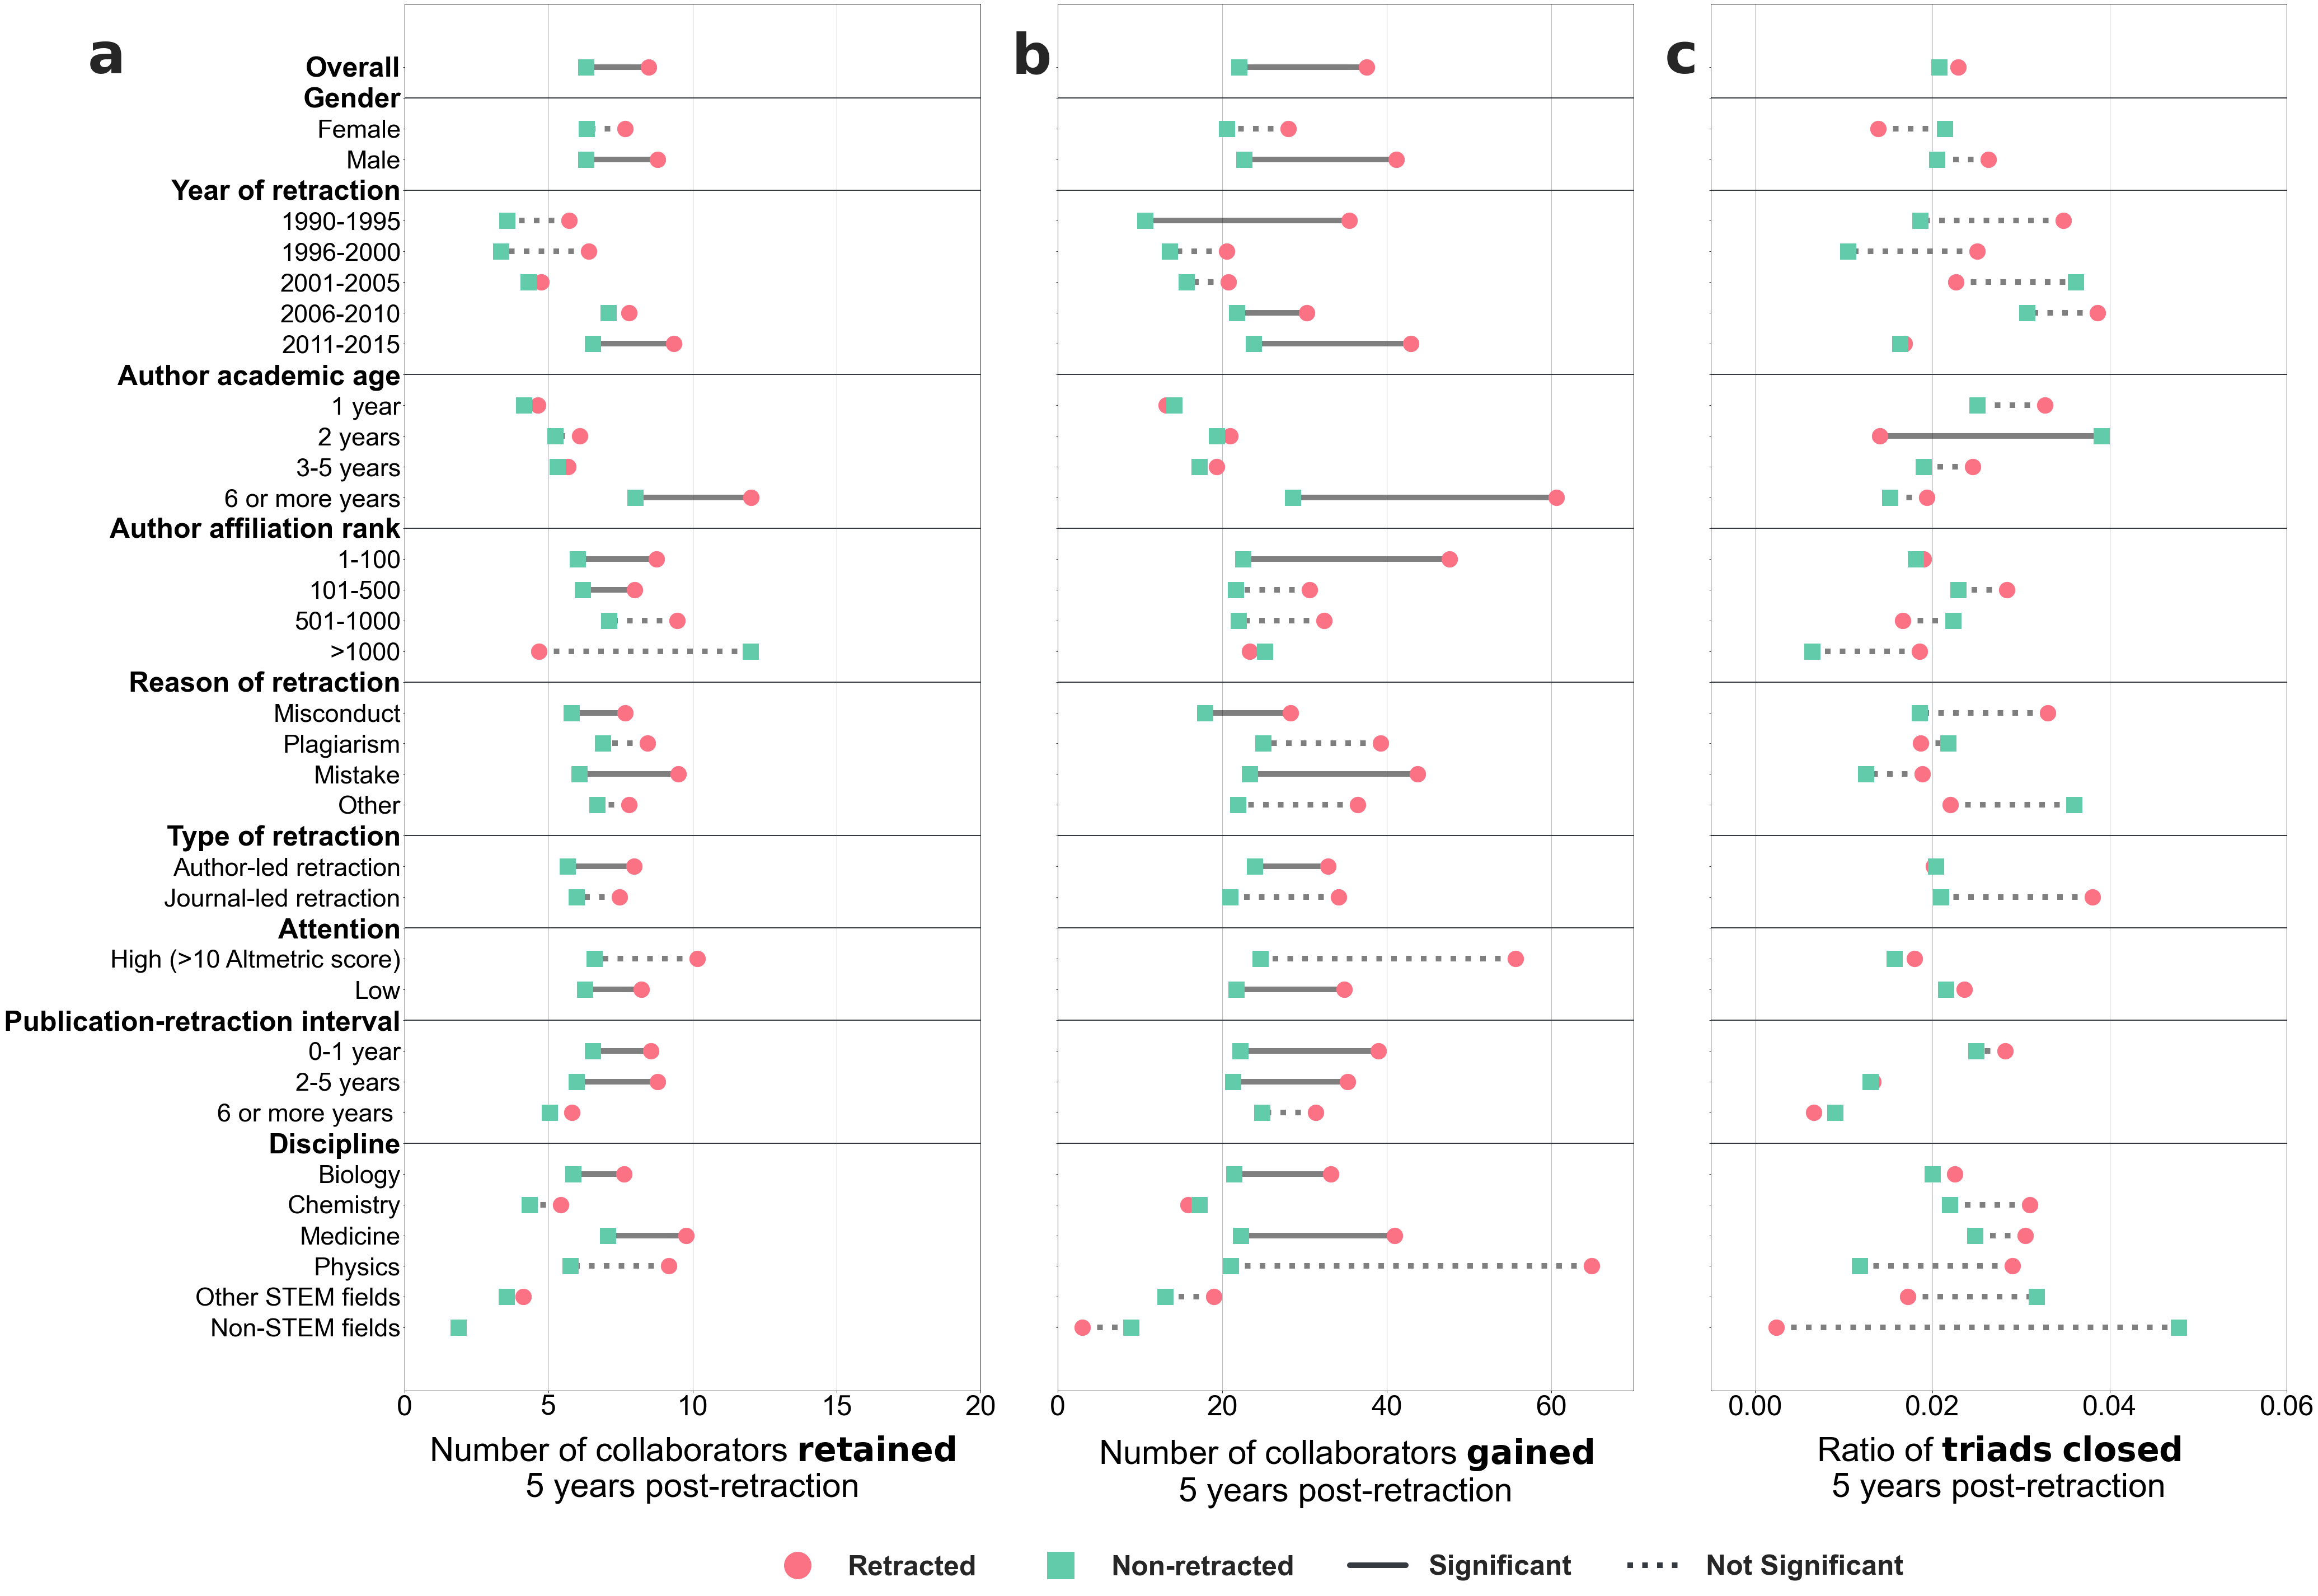

In [38]:
# Setting up the plot surface
fig = plt.figure(figsize=(60, 40))
gs = GridSpec(nrows=3, ncols=15)

number_of_strata = 10

def label_subplots(axi, labeli, xi=-0.1, yi=1.03):
    
    # Labeling the figure so that they can be referred in the paper
    axi.text(xi, yi, labeli, transform=axi.transAxes, fontfamily='DejaVu Sans',
      fontsize=100, fontweight='extra bold')

# Zeroeth axes for dot plot for retention for full matched sample
ax0 = fig.add_subplot(gs[:3, :5])

# First axes for dot plot for gain for full matched sample
ax1 = fig.add_subplot(gs[:3, 5:10], sharey = ax0)

# Second axes for dot plot for triadic closure
ax2 = fig.add_subplot(gs[:3, 10:], sharey = ax0)

# Defining colors for treatment and control
colorp = [['#fb7285','#62ccaa']] * number_of_strata


# Creating the first set of dumbell plots
create_shared_dumbbell_chart([df_retention_pre,df_gain_pre, df_triadsNC_pre], [ax0,ax1,ax2],
                             ['RetentionTreatment','GainTreatment','NCTreatment'], 
                             ['RetentionControl','GainControl', 'NCControl'],
                               colorp = colorp,
                                lst_figtype = ['','','triad_post_attrition'],
                                lst_xlim=[[0,20],[0,70],[-0.005,0.06]],
                                lst_xlabeltext=['Number of collaborators '+\
                                                 r'$\bf{retained}$'\
                                                '\n5 years post-retraction', 
                                                'Number of collaborators '+\
                                                 r'$\bf{gained}$'\
                                                '\n5 years post-retraction',
                                                'Ratio of '+\
                                                 r'$\bf{triads}$'+' '+r'$\bf{closed}$'\
                                                '\n5 years post-retraction',])

# Have to manually do this -- don't know why
plt.setp(ax1.get_yticklabels(), visible=False)
plt.setp(ax2.get_yticklabels(), visible=False)


# Defining legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Retracted',
                      markerfacecolor='#fb7285', markersize=50),
              Line2D([0], [0], marker='s', color='w', label='Non-retracted',
                      markerfacecolor='#62ccaa', markersize=50),
                Line2D([0], [0], linestyle='solid', color='#343a40', 
                       label='Significant',lw=10),
                Line2D([0], [0], linestyle='dotted', color='#343a40', label='Not Significant',
                      lw=10)]

# Adding padding between figures
plt.tight_layout(pad=8)

# Annotating figures
label_subplots(ax0, "a", xi=-0.55, yi=0.95)
label_subplots(ax1, "b", xi=-0.08, yi=0.95)
label_subplots(ax2, "c", xi=-0.08, yi=0.95)

# Adding legend
plt.legend(handles=legend_elements, loc='upper center', ncol=4,
          prop={'size': 50}, bbox_to_anchor=(-0.65, -0.10), frameon=False)


plt.savefig(OUTDIR+'/matching_analysis_samecountry_new.pdf',format='pdf', bbox_inches='tight')

## Table: Matching Analysis (Supplementary Tables)

In [37]:
## Creating supplementary tables

reorderlist = ['Overall', 
               'Gender', 'Male','Female',
               'Year of retraction','1990-1995','1996-2000','2001-2005','2006-2010','2011-2015',
               'Author academic age','1 year','2 years','3-5 years','6 or more years',
               'Author affiliation rank','1-100','101-500','501-1000','>1000',
               'Author order','First or last author', 'Middle author',
               'Reason of retraction','Misconduct','Plagiarism','Mistake','Other',
               'Type of retraction','Author-led retraction', 'Journal-led retraction',
               'Attention','High (>10 Altmetric score)','Low',
               'Publication-retraction interval','0-1 year','2-5 years','6 or more years ',
               'Discipline','Biology','Chemistry','Medicine','Physics','Other STEM fields',
                'Non-STEM fields']

groups = ['Overall','Gender','Year of retraction','Author academic age','Author affiliation rank',
                  'Author order','Reason of retraction','Type of retraction','Attention',
                  'Publication-retraction interval','Discipline']

#groups_formatted = ['\textbf{'+g+'}' for g in groups]

def format_pvalue(p):
    if p < 0.001:
        return "$<.001$"
    else:
        return "\hspace*{0.1cm}$"+str("%.3f" % round(p,3))+"$"

def format_CI(row):
    clow = str("%.3f" % round(row['conf_lower'],3))
    chigh = str("%.3f" % round(row['conf_upper'],3))
    return "[" + clow+", "+chigh+"]"
    
def format_numbers(number):
    number_str = str(number)
    return "\hspace*{0.1cm}$" + number_str + "$"

def format_groups(strata):
    if strata in groups:
        return '\\textbf{' + strata + '}'
    else:
        return strata
    
def format_lastcol(val):
    return val + r"\vspace*{0.1cm}"

def create_table(dfi, key):
    
    # Let us do some preprocessing on the dataframe first
    dfi = dfi.copy()
    dfi.index.name = 'strata'
    
    avg_treatment_col = key+'Treatment'
    avg_control_col = key+'Control'
    
    # Formatting p-values
    dfi['pvalue_welch'] = dfi['pvalue_welch'].apply(format_pvalue)
    dfi['pvalue_ks'] = dfi['pvalue_ks'].apply(format_pvalue)
    dfi['pvalue_wilcoxon'] = dfi['pvalue_wilcoxon'].apply(format_pvalue)
    
    # Formatting confidence intervals
    dfi['conf_interval'] = dfi.apply(lambda row: format_CI(row), axis=1)
    dfi = dfi.drop(columns=['conf_lower','conf_upper'])
    
    # Formatting other columns to 3 decimal points
    dfi['delta_mean'] = dfi['delta_mean'].apply(lambda n: "%.3f" % round(n,3))
    dfi[avg_treatment_col] = dfi[avg_treatment_col].apply(lambda n: "%.3f" % round(n,3))
    dfi[avg_control_col] = dfi[avg_control_col].apply(lambda n: "%.3f" % round(n,3))
    
    # Format to separate thousands for sample size
    dfi['n'] = dfi.apply(lambda x: "{:,}".format(x['n']), axis=1)
    
    # Formatting to include $
    dfi['n'] = dfi['n'].apply(format_numbers)
    
    dfi[avg_treatment_col] = dfi[avg_treatment_col].apply(format_numbers)
    dfi[avg_control_col] = dfi[avg_control_col].apply(format_numbers)
    dfi['delta_mean'] = dfi['delta_mean'].apply(format_numbers)
    
    # Let us add some dummy rows for better latex layout
    
    none_vals = ['']*len(groups[1:])
    dummy_df = pd.DataFrame({'strata':groups[1:],
                             'n':none_vals,
                            avg_treatment_col:none_vals,
                            avg_control_col:none_vals,
                            'delta_mean':none_vals,
                            'conf_interval':none_vals,
                            'pvalue_welch':none_vals,
                            'pvalue_ks':none_vals,
                            'pvalue_wilcoxon':none_vals,})

    dfi = pd.concat([dfi,dummy_df]).reset_index(drop=True)
    
    
    # Correcting the order
    dfi = dfi[['strata','n',avg_treatment_col,avg_control_col,'delta_mean',
               'conf_interval','pvalue_welch','pvalue_ks','pvalue_wilcoxon']]
    
    # Renaming
    dfi.columns = ['Group','$n_r$',r'$\mu_r$',r"$\mu_{r'}$",r'$\mu_{\delta}$',
                   r'$CI_{95\%}$',r'$p_t$',r'$p_{ks}$',r'$p_w$']
    
    # Let us order the rows
    dfi = dfi.set_index('Group').reindex(reorderlist).reset_index()
    
    # Finally let us format the groups
    dfi['Group'] = dfi['Group'].apply(format_groups)
    
    # And format >1000
    dfi['Group'] = dfi['Group'].replace(">1000","$>1000$")
    
    
    # And format >1000
    dfi['Group'] = dfi['Group'].replace("High (>10 Altmetric score)","High ($>10$ Altmetric score)")
    
    
    return dfi

### Collaborator Retention (Full Sample)

In [38]:
df_retention_pre_formatted

NameError: name 'df_retention_pre_formatted' is not defined

In [ ]:
df_retention_pre_formatted = create_table(df_retention_pre, 'Retention')

caption = "\\textbf{Results of matching analysis on \\textit{collaborator retention} for the authors who stayed}. $r$ and $r'$ represent "\
        "retracted and non-retracted authors, respectively. $n_r$ "\
        "represents the number of retracted authors. Each retracted author is compared "\
        "to a closest average matched non-retracted author in terms of the collaborators retained 5 years post retraction. "\
        "$\\mu_r$ and $\\mu_{r'}$ are the "\
        "average number of collaborators retained for retracted and non-retracted authors respectively. "\
        "$\mu_{\delta}$ is the average relative gain of $r$ over $r'$. $CI_{95\%}$ is the 95\% confidence interval for $\mu_\delta$. "\
        "$p_t$, $p_{ks}$, and $p_w$ are the p-values for the Welch t-test, Kolmogorov–Smirnov test, and Wilcoxon signed ranked test, "\
        "respectively."

label='supplementarytab:collaborator_retention_nonattrited'

prefix_latex = "\\begin{table}[H]\n{\\fontsize{9}{9}\\selectfont{\n\\caption{"\
                + caption + "}\n\\label{"\
                + label + "}\n\\begin{center}\n"

main_latex = df_retention_pre_formatted.to_latex(index=False, escape=False, 
                                     column_format='lcccccccc')

suffix_latex = "\n\\end{center}\n}}\n\\end{table}\n"

full_latex = prefix_latex + main_latex + suffix_latex

print(full_latex)

### Collaborator Gain (Full Sample)

In [ ]:
df_gain_pre_formatted

In [ ]:
df_gain_pre_formatted = create_table(df_gain_pre, 'Gain')

caption = "\\textbf{Results of matching analysis on \\textit{collaborator gained} for the authors who stayed}. $r$ and $r'$ represent "\
        "retracted and non-retracted authors, respectively. $n_r$ "\
        "represents the number of retracted authors. Each retracted author is compared "\
        "to a closest average matched non-retracted author in terms of the collaborators gained 5 years post retraction. "\
        "$\\mu_r$ and $\\mu_{r'}$ are the "\
        "average number of collaborators gained for retracted and non-retracted authors respectively. "\
        "$\mu_{\delta}$ is the average relative gain of $r$ over $r'$. $CI_{95\%}$ is the 95\% confidence interval for $\mu_\delta$. "\
        "$p_t$, $p_{ks}$, and $p_w$ are the p-values for the Welch t-test, Kolmogorov–Smirnov test, and Wilcoxon signed ranked test, "\
        "respectively."

label='supplementarytab:collaborator_gain_nonattrited'

prefix_latex = "\\begin{table}[H]\n{\\fontsize{9}{9}\\selectfont{\n\\caption{"\
                + caption + "}\n\\label{"\
                + label + "}\n\\begin{center}\n"

main_latex = df_gain_pre_formatted.to_latex(index=False, escape=False, 
                                     column_format='lcccccccc')

suffix_latex = "\n\\end{center}\n}}\n\\end{table}\n"

full_latex = prefix_latex + main_latex + suffix_latex

print(full_latex)

### Triadic Closure (Full Sample)

In [ ]:
df_triadsNC_pre_formatted = create_table(df_triadsNC_pre, 'NC')

caption = "\\textbf{Results of matching analysis on \\textit{triadic closure} for the authors who stayed}. $r$ and $r'$ represent "\
        "retracted and non-retracted authors respectively. $n_r$ "\
        "represents the number of retracted authors. Each retracted author is compared "\
        "to a closest average matched non-retracted author in terms of the ratio of the triads closed 5 years post-retraction. "\
        "$\\mu_r$ and $\\mu_{r'}$ are the "\
        "average ratio of the triads closed for retracted and non-retracted authors respectively. "\
        "$\mu_{\delta}$ is the average relative gain of $r$ over $r'$. $CI_{95\%}$ is the 95\% confidence interval for $\mu_\delta$. "\
        "$p_t$, $p_{ks}$, and $p_w$ are the p-values for the Welch t-test, Kolmogorov–Smirnov test, and Wilcoxon signed ranked test, "\
        "respectively."

label='supplementarytab:collaborator_triadicclosure_nonattrited'


prefix_latex = "\\begin{table}[H]\n{\\fontsize{9}{9}\\selectfont{\n\\caption{"\
                + caption + "}\n\\label{"\
                + label + "}\n\\begin{center}\n"

main_latex = df_triadsNC_pre_formatted.to_latex(index=False, escape=False, 
                                     column_format='lcccccccc')

suffix_latex = "\n\\end{center}\n}}\n\\end{table}\n"

full_latex = prefix_latex + main_latex + suffix_latex

print(full_latex)